**Case study: To predict tags based on the content that was there in the questions posted on STACK OVERFLOW**

In [0]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
#from skmultilearn.adapt import mlknn
#from skmultilearn.problem_transform import ClassifierChain
#from skmultilearn.problem_transform import BinaryRelevance
#from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

In [0]:
import nltk

In [0]:
from sklearn.multiclass import OneVsRestClassifier


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

    100% |████████████████████████████████| 993kB 21.4MB/s 


In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':'1KtfKaIl8lMJqjUcfmQMwxLlwWEaCSX4q'}) 
downloaded.GetContentFile('tag_prediction_data')

df = pd.read_csv('tag_prediction_data')

# Stack Overflow: Tag Prediction

<h1>1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p style='font-size:18px'><b> Description </b></p>
<p>
Stack Overflow is the largest, most trusted online community for developers to learn, share their programming knowledge, and build their careers.<br />
<br />
Stack Overflow is something which every programmer use one way or another. Each month, over 50 million developers come to Stack Overflow to learn, share their knowledge, and build their careers. It features questions and answers on a wide range of topics in computer programming. The website serves as a platform for users to ask and answer questions, and, through membership and active participation, to vote questions and answers up or down and edit questions and answers in a fashion similar to a wiki or Digg. As of April 2014 Stack Overflow has over 4,000,000 registered users, and it exceeded 10,000,000 questions in late August 2015. Based on the type of tags assigned to questions, the top eight most discussed topics on the site are: Java, JavaScript, C#, PHP, Android, jQuery, Python and HTML.<br />
<br />
</p>

<p style='font-size:18px'><b> Problem Statemtent </b></p>
Suggest the tags based on the content that was there in the question posted on Stackoverflow.

<p style='font-size:18px'><b> Source:  </b> https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/</p>


<h2> 1.3 Real World / Business Objectives and Constraints </h2>

1. Predict as many tags as possible with high precision and recall.
2. Incorrect tags could impact customer experience on StackOverflow.
3. No strict latency constraints.

<h1>2. Machine Learning problem </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

Refer: https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/data
<br>
All of the data is in 2 files: Train and Test.<br />
<pre>
<b>Train.csv</b> contains 4 columns: Id,Title,Body,Tags.<br />
<b>Test.csv</b> contains the same columns but without the Tags, which you are to predict.<br />
<b>Size of Train.csv</b> - 6.75GB<br />
<b>Size of Test.csv</b> - 2GB<br />
<b>Number of rows in Train.csv</b> = 6034195<br />
</pre>
The questions are randomized and contains a mix of verbose text sites as well as sites related to math and programming. The number of questions from each site may vary, and no filtering has been performed on the questions (such as closed questions).<br />
<br />


__Data Field Explaination__

Dataset contains 6,034,195 rows. The columns in the table are:<br />
<pre>
<b>Id</b> - Unique identifier for each question<br />
<b>Title</b> - The question's title<br />
<b>Body</b> - The body of the question<br />
<b>Tags</b> - The tags associated with the question in a space-seperated format (all lowercase, should not contain tabs '\t' or ampersands '&')<br />
</pre>

<br />

<h3>2.1.2 Example Data point </h3>

<pre>
<b>Title</b>:  Implementing Boundary Value Analysis of Software Testing in a C++ program?
<b>Body </b>: <pre><code>
        #include&lt;
        iostream&gt;\n
        #include&lt;
        stdlib.h&gt;\n\n
        using namespace std;\n\n
        int main()\n
        {\n
                 int n,a[n],x,c,u[n],m[n],e[n][4];\n         
                 cout&lt;&lt;"Enter the number of variables";\n         cin&gt;&gt;n;\n\n         
                 cout&lt;&lt;"Enter the Lower, and Upper Limits of the variables";\n         
                 for(int y=1; y&lt;n+1; y++)\n         
                 {\n                 
                    cin&gt;&gt;m[y];\n                 
                    cin&gt;&gt;u[y];\n         
                 }\n         
                 for(x=1; x&lt;n+1; x++)\n         
                 {\n                 
                    a[x] = (m[x] + u[x])/2;\n         
                 }\n         
                 c=(n*4)-4;\n         
                 for(int a1=1; a1&lt;n+1; a1++)\n         
                 {\n\n             
                    e[a1][0] = m[a1];\n             
                    e[a1][1] = m[a1]+1;\n             
                    e[a1][2] = u[a1]-1;\n             
                    e[a1][3] = u[a1];\n         
                 }\n         
                 for(int i=1; i&lt;n+1; i++)\n         
                 {\n            
                    for(int l=1; l&lt;=i; l++)\n            
                    {\n                 
                        if(l!=1)\n                 
                        {\n                    
                            cout&lt;&lt;a[l]&lt;&lt;"\\t";\n                 
                        }\n            
                    }\n            
                    for(int j=0; j&lt;4; j++)\n            
                    {\n                
                        cout&lt;&lt;e[i][j];\n                
                        for(int k=0; k&lt;n-(i+1); k++)\n                
                        {\n                    
                            cout&lt;&lt;a[k]&lt;&lt;"\\t";\n               
                        }\n                
                        cout&lt;&lt;"\\n";\n            
                    }\n        
                 }    \n\n        
                 system("PAUSE");\n        
                 return 0;    \n
        }\n
        </code></pre>\n\n
        <p>The answer should come in the form of a table like</p>\n\n
        <pre><code>       
        1            50              50\n       
        2            50              50\n       
        99           50              50\n       
        100          50              50\n       
        50           1               50\n       
        50           2               50\n       
        50           99              50\n       
        50           100             50\n       
        50           50              1\n       
        50           50              2\n       
        50           50              99\n       
        50           50              100\n
        </code></pre>\n\n
        <p>if the no of inputs is 3 and their ranges are\n
        1,100\n
        1,100\n
        1,100\n
        (could be varied too)</p>\n\n
        <p>The output is not coming,can anyone correct the code or tell me what\'s wrong?</p>\n'
<b>Tags </b>: 'c++ c'
</pre>

<h2>2.2 Mapping the real-world problem to a Machine Learning Problem </h2>

<h3> 2.2.1 Type of Machine Learning Problem </h3>

<p> It is a multi-label classification problem  <br>
<b>Multi-label Classification</b>: Multilabel classification assigns to each sample a set of target labels. This can be thought as predicting properties of a data-point that are not mutually exclusive, such as topics that are relevant for a document. A question on Stackoverflow might be about any of C, Pointers, FileIO and/or memory-management at the same time or none of these. <br>
__Credit__: http://scikit-learn.org/stable/modules/multiclass.html
</p>

<h3>2.2.2 Performance metric </h3>

<b>Micro-Averaged F1-Score (Mean F Score) </b>: 
The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

<i>F1 = 2 * (precision * recall) / (precision + recall)</i><br>

In the multi-class and multi-label case, this is the weighted average of the F1 score of each class. <br>

<b>'Micro f1 score': </b><br>
Calculate metrics globally by counting the total true positives, false negatives and false positives. This is a better metric when we have class imbalance.
<br>

<b>'Macro f1 score': </b><br>
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
<br>

https://www.kaggle.com/wiki/MeanFScore <br>
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html <br>
<br>
<b> Hamming loss </b>: The Hamming loss is the fraction of labels that are incorrectly predicted. <br>
https://www.kaggle.com/wiki/HammingLoss <br>

<h1> 3. Exploratory Data Analysis </h1>

<h2> 3.1 Data Loading and Cleaning </h2>

<h3>3.1.1 Using Pandas with SQLite to Load the data</h3>

In [0]:
# Creating DataBase
disk_engine = create_engine('sqlite:///train.db')

In [0]:
#Loading dataframe to database
df.to_sql('data' , disk_engine)

<h3> 3.1.2 Counting the number of rows </h3>

In [0]:
con = sqlite3.connect('train.db')
num_rows = pd.read_sql_query("""SELECT count(*) FROM data""", con)
con.close()
print('Number of rows: ',num_rows['count(*)'])


Number of rows:  0    500000
Name: count(*), dtype: int64


<h3>3.1.3 Checking for duplicates </h3>

In [0]:
#Learn SQl: https://www.w3schools.com/sql/default.asp
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    df_no_dup = pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM data GROUP BY Title, Body, Tags', con)
    con.close()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the first to genarate train.db file")

Time taken to run this cell : 0:00:06.789780


In [0]:
df_no_dup.head()
# we can observe that there are duplicates

,Title,Body,Tags,cnt_dup
0,"""SQL Injection"" issue preventing correct for...",<p>So I've been checking everything I can thin...,php forms,1
1,"$f$ a continuous function in [0,1], Show: $\l...","<p>Let $f$ be a continuous function in [0,1] a...",calculus,1
2,*** Exception: Prelude.read: no parse in Hask...,<p>This portion of code should read in two or ...,parsing haskell expression,1
3,500 Internal Server Error in ASP.NET MVC,<p>I am working in ASP.NET MVC. I am using par...,asp.net-mvc,1
4,Accessing @Local Session Bean from an exposed...,<p>What I am trying to do should be very strai...,ejb resteasy,2


In [0]:
print("number of duplicate questions :", num_rows['count(*)'].values[0]- df_no_dup.shape[0], "(",(1-((df_no_dup.shape[0])/(num_rows['count(*)'].values[0])))*100,"% )")

number of duplicate questions : 14164 ( 2.832800000000002 % )


In [0]:
# number of times each question appeared in our database
df_no_dup['cnt_dup'].value_counts()

1    471818
2     13872
3       146
Name: cnt_dup, dtype: int64

In [0]:
start = datetime.now()
df_no_dup["tag_count"] = df_no_dup["Tags"].apply(lambda text: len(text.split(" ")))
# adding a new feature number of tags per question
print("Time taken to run this cell :", datetime.now() - start)
df_no_dup.head()

Time taken to run this cell : 0:00:00.368823


,Title,Body,Tags,cnt_dup,tag_count
0,"""SQL Injection"" issue preventing correct for...",<p>So I've been checking everything I can thin...,php forms,1,2
1,"$f$ a continuous function in [0,1], Show: $\l...","<p>Let $f$ be a continuous function in [0,1] a...",calculus,1,1
2,*** Exception: Prelude.read: no parse in Hask...,<p>This portion of code should read in two or ...,parsing haskell expression,1,3
3,500 Internal Server Error in ASP.NET MVC,<p>I am working in ASP.NET MVC. I am using par...,asp.net-mvc,1,1
4,Accessing @Local Session Bean from an exposed...,<p>What I am trying to do should be very strai...,ejb resteasy,2,2


In [0]:
# distribution of number of tags per question
df_no_dup.tag_count.value_counts()

3    139065
2    129207
4     93550
1     66623
5     57391
Name: tag_count, dtype: int64

In [0]:
#Creating a new database with no duplicates
if not os.path.isfile('train_no_dup.db'):
    disk_dup = create_engine("sqlite:///train_no_dup.db")
    no_dup = pd.DataFrame(df_no_dup, columns=['Title', 'Body', 'Tags'])
    no_dup.to_sql('no_dup_train',disk_dup)

In [0]:
#This method seems more appropriate to work with this much data.
#creating the connection with database file.
if os.path.isfile('train_no_dup.db'):
    start = datetime.now()
    con = sqlite3.connect('train_no_dup.db')
    tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", con)
    #Always remember to close the database
    con.close()

    # Let's now drop unwanted column.
    tag_data.drop(tag_data.index[0], inplace=True)
    #Printing first 5 columns from our data frame
    tag_data.head()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cells to genarate train.db file")

Time taken to run this cell : 0:00:00.747133


In [0]:
tag_data.head()

,Tags
1,calculus
2,parsing haskell expression
3,asp.net-mvc
4,ejb resteasy
5,algebraic-geometry complex-analysis riemann-su...


<h2> 3.2 Analysis of Tags </h2>

<h3> 3.2.1 Total number of unique tags </h3>

In [0]:
# Importing & Initializing the "CountVectorizer" object, which 
#is scikit-learn's bag of words tool.

#by default 'split()' will tokenize each tag using space.
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of strings.
tag_dtm = vectorizer.fit_transform(tag_data['Tags'])

In [0]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 485835
Number of unique tags : 30429


In [0]:
#'get_feature_name()' gives us the vocabulary.
tags = vectorizer.get_feature_names()
#Lets look at the tags we have.
print("Some of the tags we have :", tags[:10])

Some of the tags we have : ['.a', '.app', '.aspxauth', '.bash-profile', '.class-file', '.doc', '.each', '.emf', '.exe', '.hgtags']


<h3> 3.2.3 Number of times a tag appeared </h3>

In [0]:
# https://stackoverflow.com/questions/15115765/how-to-access-sparse-matrix-elements
#Lets now store the document term matrix in a dictionary.
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [0]:
#Saving this dictionary to csv files.
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.a,3
1,.app,8
2,.aspxauth,3
3,.bash-profile,13
4,.class-file,5


In [0]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

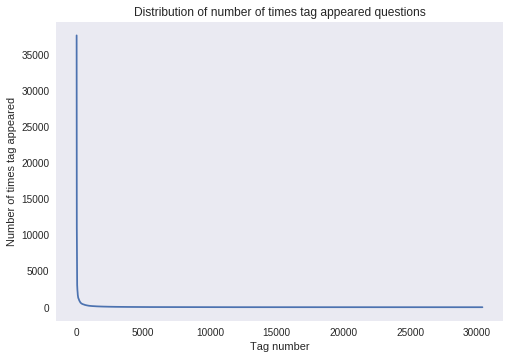

In [0]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

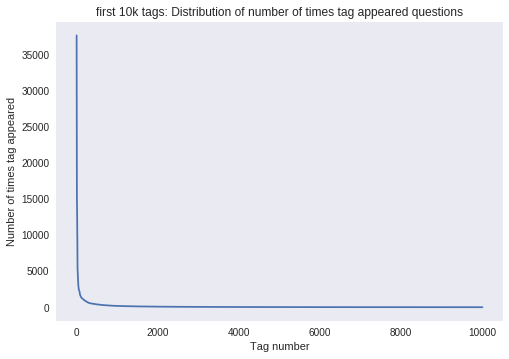

400 [37603  4909  2566  2052  1529  1279  1178  1055   924   854   747   686
   612   573   539   502   479   453   434   416   397   386   368   349
   335   318   309   295   283   273   263   253   244   237   228   219
   210   203   198   193   186   182   178   173   169   165   162   158
   154   152   148   145   143   141   138   135   132   129   126   123
   121   118   116   114   112   111   109   108   106   104   103   101
   100    98    97    95    93    91    90    88    87    86    85    83
    82    81    80    79    78    77    76    75    74    73    72    71
    70    69    68    67    66    65    65    64    63    62    62    61
    60    59    58    57    57    56    55    55    54    53    53    52
    52    51    51    50    50    49    49    48    47    47    47    46
    46    45    45    44    44    43    43    43    42    42    42    41
    41    41    40    40    39    39    39    38    38    38    37    37
    37    36    36    36    36    35    35    3

In [0]:
plt.plot(tag_counts[0:10000])
plt.title('first 10k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:10000:25]), tag_counts[0:10000:25])

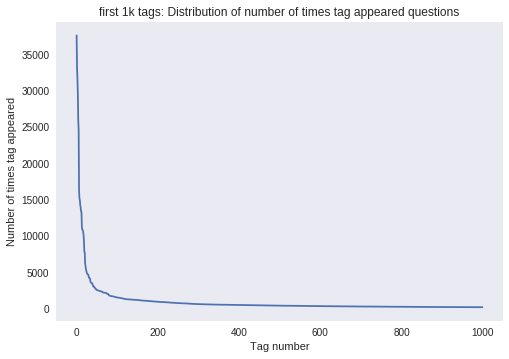

200 [37603 24567 13873 10826  7706  4909  4279  3585  3221  2827  2566  2442
  2376  2222  2176  2052  1801  1708  1670  1576  1529  1480  1429  1370
  1315  1279  1257  1234  1215  1199  1178  1138  1109  1092  1072  1055
  1030   998   981   949   924   910   900   881   865   854   822   802
   790   769   747   739   725   716   701   686   664   646   636   620
   612   602   594   591   577   573   562   555   548   541   539   534
   525   514   506   502   496   494   487   484   479   475   470   462
   457   453   447   447   441   438   434   429   427   421   419   416
   407   404   402   400   397   394   391   389   388   386   382   379
   379   373   368   365   363   360   355   349   347   341   338   336
   335   331   326   324   322   318   317   314   312   311   309   304
   302   300   299   295   292   290   286   284   283   281   279   277
   275   273   271   269   268   266   263   260   258   257   255   253
   250   249   247   245   244   242   241   24

In [0]:
plt.plot(tag_counts[0:1000])
plt.title('first 1k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:1000:5]), tag_counts[0:1000:5])

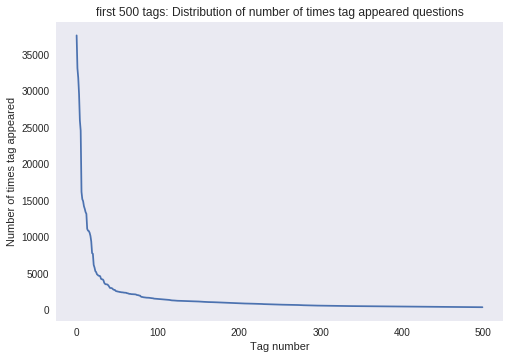

100 [37603 24567 13873 10826  7706  4909  4279  3585  3221  2827  2566  2442
  2376  2222  2176  2052  1801  1708  1670  1576  1529  1480  1429  1370
  1315  1279  1257  1234  1215  1199  1178  1138  1109  1092  1072  1055
  1030   998   981   949   924   910   900   881   865   854   822   802
   790   769   747   739   725   716   701   686   664   646   636   620
   612   602   594   591   577   573   562   555   548   541   539   534
   525   514   506   502   496   494   487   484   479   475   470   462
   457   453   447   447   441   438   434   429   427   421   419   416
   407   404   402   400]


In [0]:
plt.plot(tag_counts[0:500])
plt.title('first 500 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:500:5]), tag_counts[0:500:5])

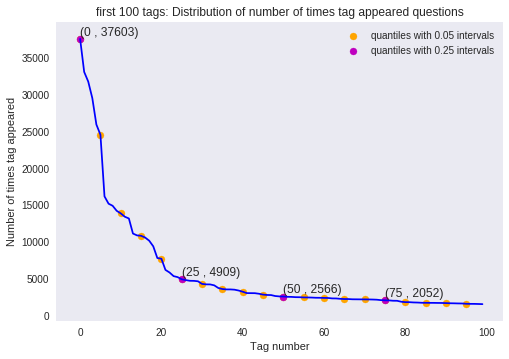

20 [37603 24567 13873 10826  7706  4909  4279  3585  3221  2827  2566  2442
  2376  2222  2176  2052  1801  1708  1670  1576]


In [0]:
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

In [0]:
# Store tags greater than 10K in one list
lst_tags_gt_10k = tag_df[tag_df.Counts>10000].Tags
#Print the length of the list
print ('{} Tags are used more than 10000 times'.format(len(lst_tags_gt_10k)))
# Store tags greater than 100K in one list
lst_tags_gt_100k = tag_df[tag_df.Counts>100000].Tags
#Print the length of the list.
print ('{} Tags are used more than 100000 times'.format(len(lst_tags_gt_100k)))

18 Tags are used more than 10000 times
0 Tags are used more than 100000 times


<b>Observations:</b><br />
1. There are total 153 tags which are used more than 10000 times.
2. 14 tags are used more than 100000 times.
3. Most frequent tag (i.e. c#) is used 331505 times.
4. Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm.

<h3> 3.2.4 Tags Per Question </h3>

In [0]:
#Storing the count of tag in each question in list 'tag_count'
tag_quest_count = tag_dtm.sum(axis=1).tolist()
#Converting list of lists into single list, we will get [[3], [4], [2], [2], [3]] and we are converting this to [3, 4, 2, 2, 3]
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:5])

We have total 485835 datapoints.
[1, 3, 1, 2, 4]


In [0]:
print( "Maximum number of tags per question: %d"%max(tag_quest_count))
print( "Minimum number of tags per question: %d"%min(tag_quest_count))
print( "Avg. number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Avg. number of tags per question: 2.888604


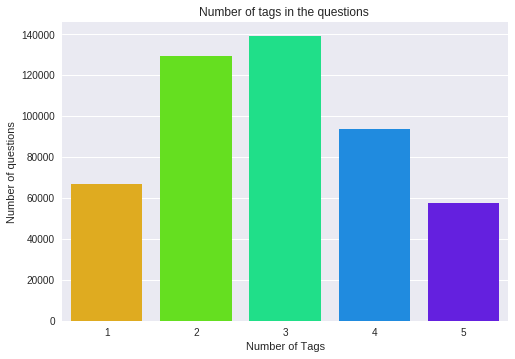

In [0]:
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

<b>Observations:</b><br />
1. Maximum number of tags per question: 5
2. Minimum number of tags per question: 1
3. Avg. number of tags per question: 2.899
4. Most of the questions are having 2 or 3 tags

<h3>3.2.5 Most Frequent Tags </h3>

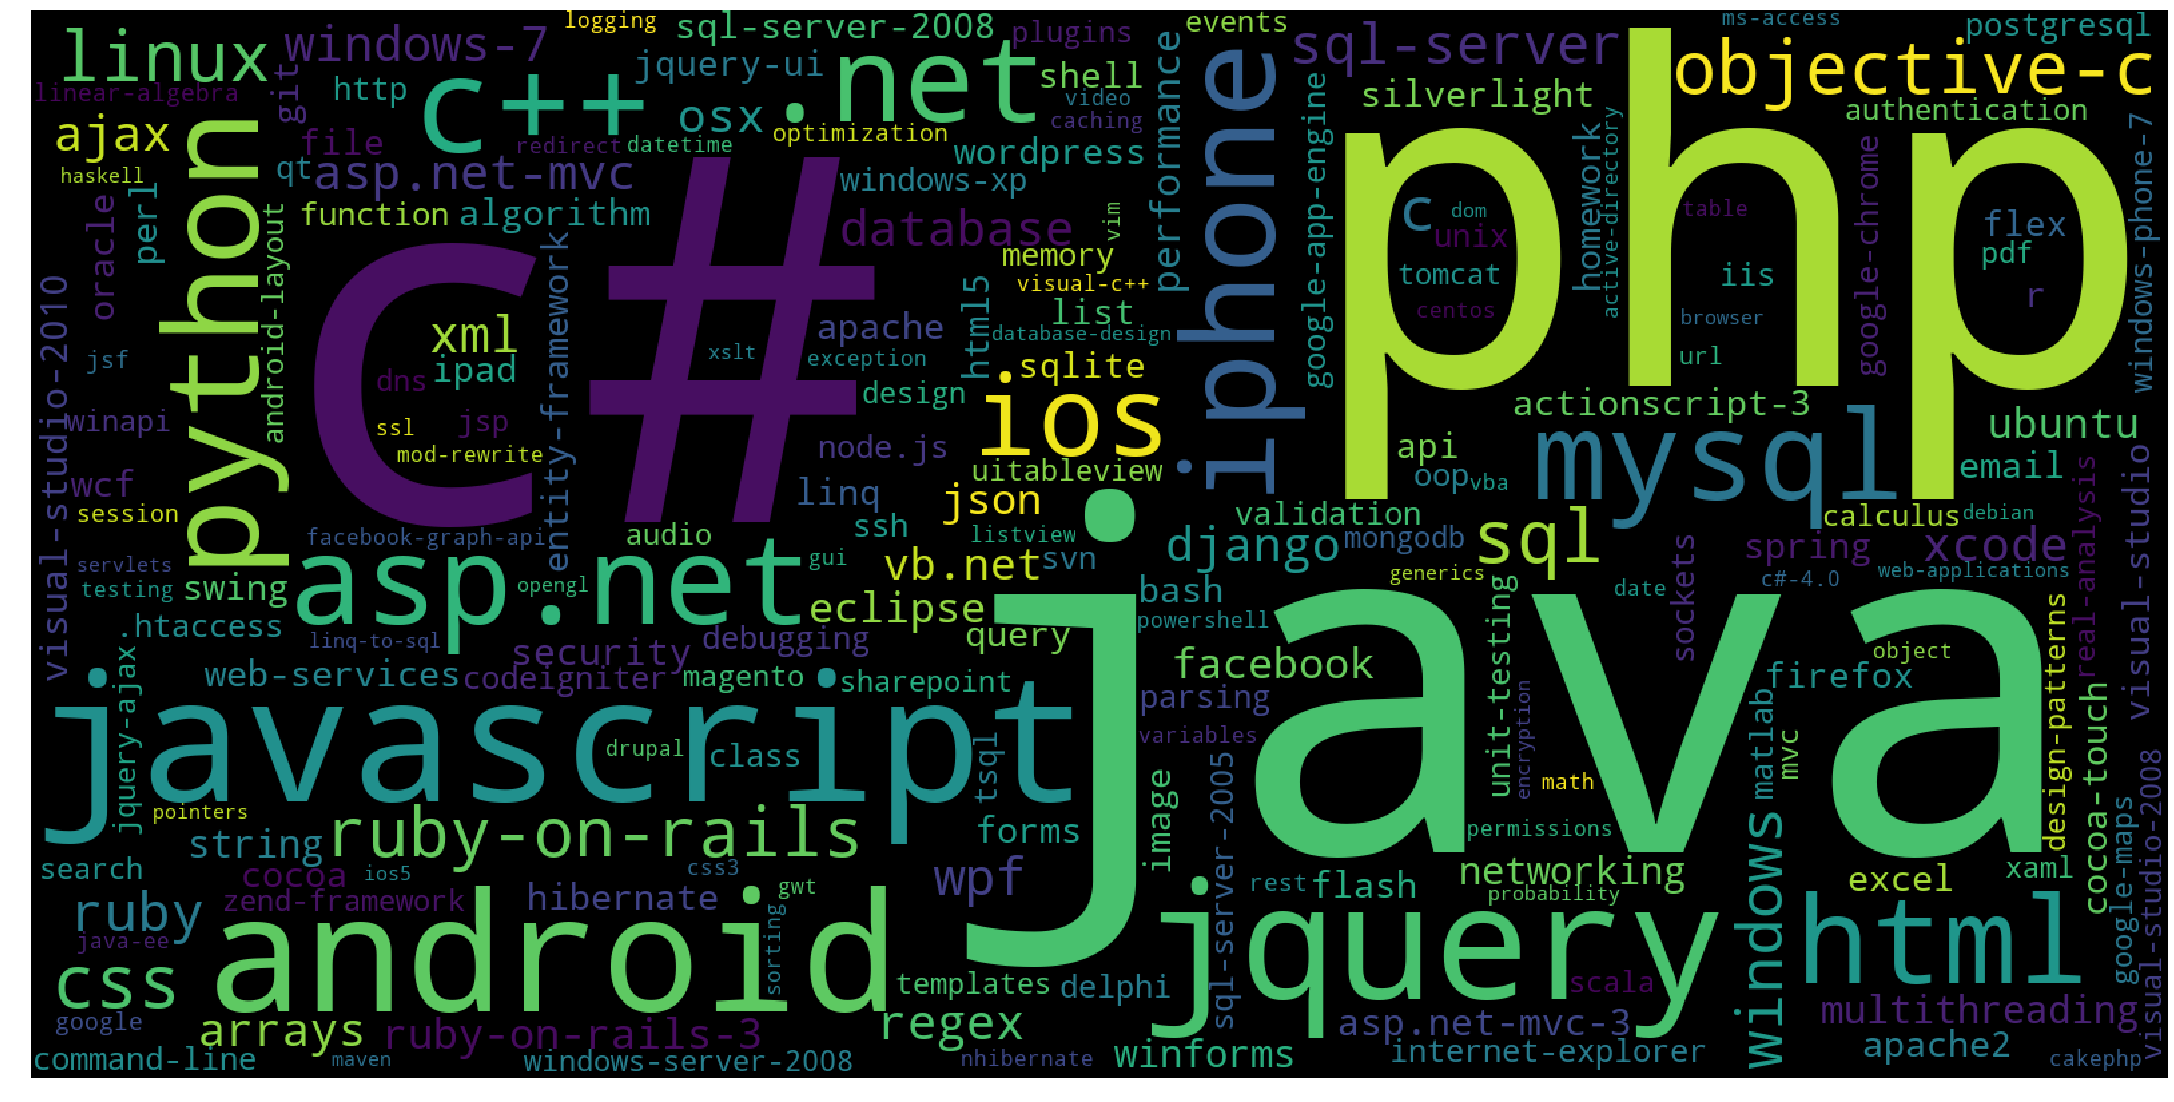

Time taken to run this cell : 0:00:04.779871


In [0]:
# Ploting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

<b>Observations:</b><br />
A look at the word cloud shows that "c#", "java", "php", "asp.net", "javascript", "c++" are some of the most frequent tags.

<h3> 3.2.6 The top 20 tags </h3>

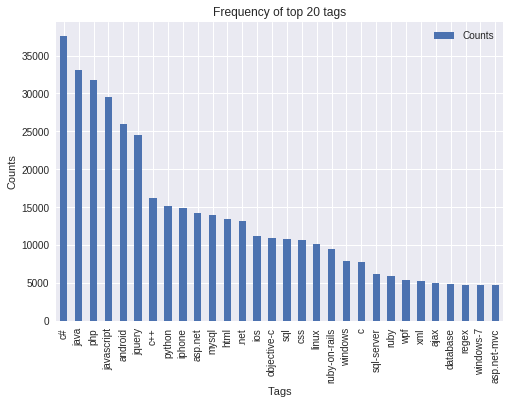

In [0]:
i=np.arange(30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

<b>Observations:</b><br />
1. Majority of the most frequent tags are programming language.
2. C# is the top most frequent programming language.
3. Android, IOS, Linux and windows are among the top most frequent operating systems.

<h3> 3.3 Cleaning and preprocessing of Questions </h3>

<h3> 3.3.1 Preprocessing </h3>

### Preprocessing phase involves following steps:
1. removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Stemming 

In [0]:
no_dup1 = no_dup.head(100000)              # due to computation limitation taking only 100k points

In [0]:
no_dup1.head()

,Title,Body,Tags
0,"""SQL Injection"" issue preventing correct for...",<p>So I've been checking everything I can thin...,php forms
1,"$f$ a continuous function in [0,1], Show: $\l...","<p>Let $f$ be a continuous function in [0,1] a...",calculus
2,*** Exception: Prelude.read: no parse in Hask...,<p>This portion of code should read in two or ...,parsing haskell expression
3,500 Internal Server Error in ASP.NET MVC,<p>I am working in ASP.NET MVC. I am using par...,asp.net-mvc
4,Accessing @Local Session Bean from an exposed...,<p>What I am trying to do should be very strai...,ejb resteasy


In [0]:
nltk.download('stopwords')
stop = set(stopwords.words('english'))  # set of english stopwords
stop.remove("not")  
print(stop)

sno = nltk.stem.SnowballStemmer('english') # initializing snowball stemmer



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
{"won't", 'from', 'during', 'then', 'own', 'yourself', 'under', "you've", 'if', "aren't", "couldn't", 'because', 'all', 'i', 'my', "needn't", 'aren', 'couldn', 'can', 'didn', 'on', 'with', 'down', 'very', 'hasn', 'ourselves', 'or', "you're", 'each', 've', 'd', 'wouldn', 'what', 'its', 'same', 'only', 's', 'ma', 'won', 'yourselves', 'haven', 'have', 't', "don't", 'doing', 'were', 'wasn', 'does', 'their', 'some', 'who', 'before', 'just', 'hadn', 'herself', 'having', 'your', 'through', "you'll", 'into', 'did', 'off', 'it', 'which', 'here', "mightn't", 'our', "shan't", 'to', 'itself', 'be', 'don', 'above', 'where', "shouldn't", 'for', 'no', 'an', "isn't", 'but', 'few', 'needn', "haven't", "weren't", 'he', 'mustn', 'has', 'o', "mustn't", "that'll", 'further', "should've", 'once', 'this', 'his', 'do', "hadn't", 'doesn', 'had', 'at', 'are', 'they', 'and', 'am', 'we', 'how', "it's", '

In [0]:
def cleanhtml(sentence):    # function for removing html
    cleanr = re.compile('<.*?>')
    cleantxt = re.sub(cleanr , ' ' , str(sentence))
    return cleantxt

def cleanpunc(sentence):    # function for removing punctuation
    clean = re.sub(r'[?|!|\'|"|#|.|,|)|(|\|/]', r' ' , sentence)
    return clean


In [0]:
i = 0
final_string = []

str1 = ' '
s = ' '
ss = no_dup1['Title'].values
for sent in ss:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # removing HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):# checking if word is not alpha numeric and length is greater than 2
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    
    final_string.append(str1)
    i+=1
           

In [0]:
no_dup1['processed_Title'] = final_string  # adding extra column for preprocessed review
no_dup1['processed_Title'] = no_dup1['processed_Title'].str.decode("utf8")


In [0]:
no_dup1.drop(['Title' , 'Body'] , axis =1 , inplace = True)
no_dup1.head()


,Tags,processed_Title
0,php forms,sql inject issu prevent correct form submiss php
1,calculus,continu function
2,parsing haskell expression,prelud pars haskel pars express recurs
3,asp.net-mvc,intern server error asp net mvc
4,ejb resteasy,access session bean expos resteasi interfac


In [0]:
print("number of data points in sample :", no_dup1.shape[0])
print("number of dimensions :", no_dup1.shape[1])

number of data points in sample : 100000
number of dimensions : 2


<h1>4. Machine Learning Models </h1>

<h2> 4.1 Converting tags for multilabel problems </h2>

<table>
<tr>
<th>X</th><th>y1</th><th>y2</th><th>y3</th><th>y4</th>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>1</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>1</td><td>0</td><td>0</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>0</td><td>0</td>
</tr>
</table>

In [0]:
# binary='true' will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(no_dup1['Tags'])


In [0]:
multilabel_y.shape[1]

18435

__ We will sample the number of tags instead considering all of them (due to limitation of computing power) __

In [0]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [0]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=no_dup1.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

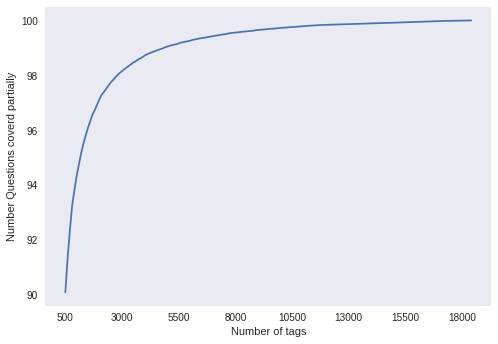

In [0]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()

In [0]:
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 9903 out of  100000


In [0]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample : 18435
number of tags taken : 500 ( 2.7122321670735015 %)


__ We consider top 2.7% tags which covers  90.097% of the questions __

<h2>4.2 Split the data into test and train (70:30) </h2>





In [0]:
total_size=no_dup1.shape[0]
train_size=int(0.70*total_size)

x_train=no_dup1.head(train_size)
x_test=no_dup1.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [0]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (70000, 500)
Number of data points in test data : (30000, 500)


<h2>4.3 Featurizing data </h2>

In [0]:
vectorizer = CountVectorizer(min_df=0.00009, max_features=20000,   ngram_range=(1,4))
x_train_multilabel = vectorizer.fit_transform(x_train['processed_Title'])
x_test_multilabel = vectorizer.transform(x_test['processed_Title'])

In [0]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (70000, 7987) Y : (70000, 500)
Dimensions of test data X: (30000, 7987) Y: (30000, 500)


<h2> 4.4 Applying Logistic Regression with OneVsRest Classifier </h2>

In [0]:
from sklearn.model_selection import GridSearchCV


In [0]:
tuned_parameters = [{'estimator__C': [0.001,0.1,10,1000]}]
    

LR_clf = OneVsRestClassifier(LogisticRegression())
LR_using_grid = GridSearchCV(LR_clf, tuned_parameters,scoring = 'f1_micro', cv=2, n_jobs=-1)

LR_using_grid.fit(x_train_multilabel, y_train)


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=None),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'estimator__C': [0.001, 0.1, 10, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=0)

In [0]:
print("best parameter" ,LR_using_grid.best_params_ )

best parameter {'estimator__C': 10}


In [0]:
LR_model = OneVsRestClassifier(LogisticRegression(C=10) , n_jobs = -1)
LR_model.fit(x_train_multilabel, y_train)

In [0]:
predictions = LR_model.predict(x_test_multilabel)

In [0]:

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))


accuracy : 0.16936666666666667
macro f1 score : 0.2729120854401154
micro f1 scoore : 0.3616427675101424
hamming loss : 0.0034931333333333334
Precision recall report :
               precision    recall  f1-score   support

           0       0.39      0.24      0.29      2585
           1       0.72      0.63      0.67      1348
           2       0.67      0.30      0.42      1871
           3       0.70      0.35      0.47      1611
           4       0.63      0.30      0.41      1556
           5       0.34      0.22      0.27       922
           6       0.65      0.27      0.38       914
           7       0.69      0.39      0.50       974
           8       0.32      0.11      0.17       959
           9       0.65      0.45      0.53       590
          10       0.59      0.30      0.40       877
          11       0.64      0.39      0.49      1080
          12       0.39      0.18      0.25       731
          13       0.44      0.25      0.32       683
          14       0.

In [0]:
from sklearn.externals import joblib
joblib.dump(classifier, 'lr_with_equal_weight.pkl') 

<h1> 5. Linear SVM </h1>

In [0]:
tuned_parameters = [{'estimator__alpha': [0.001,0.1,10,1000]}]

linear_svm_clf = OneVsRestClassifier(SGDClassifier(loss='hinge'))
linear_svm_using_grid = GridSearchCV(linear_svm_clf, tuned_parameters,scoring = 'f1_micro', cv=2,n_jobs=-1)

linear_svm_using_grid.fit(x_train_multilabel, y_train)

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'estimator__alpha': [0.001, 0.1, 10, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=0)

In [0]:
print("best parameter" ,linear_svm_using_grid.best_params_ )

best parameter {'estimator__alpha': 0.001}


In [0]:
linear_svm_model = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.001),n_jobs=-1)
linear_svm_model.fit(x_train_multilabel, y_train)
prediction = linear_svm_model.predict (x_test_multilabel)


In [0]:
print("accuracy :",metrics.accuracy_score(y_test,prediction))
print("macro f1 score :",metrics.f1_score(y_test, prediction, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, prediction, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,prediction))
print("Precision recall report :\n",metrics.classification_report(y_test, prediction))


accuracy : 0.17083333333333334
macro f1 score : 0.06785390216512897
micro f1 scoore : 0.24511641203189022
hamming loss : 0.0031688
Precision recall report :
               precision    recall  f1-score   support

           0       0.67      0.00      0.00      2585
           1       0.96      0.40      0.57      1348
           2       0.86      0.25      0.39      1871
           3       0.93      0.32      0.48      1611
           4       0.89      0.25      0.39      1556
           5       0.46      0.01      0.02       922
           6       0.87      0.25      0.38       914
           7       0.89      0.36      0.51       974
           8       0.49      0.17      0.26       959
           9       0.82      0.29      0.43       590
          10       0.86      0.22      0.35       877
          11       0.96      0.30      0.45      1080
          12       0.00      0.00      0.00       731
          13       0.73      0.16      0.26       683
          14       0.00      0.

In [0]:
from prettytable import PrettyTable

In [0]:
x = PrettyTable()

In [0]:
x.field_names = ["Model", "Accuracy", "Hamming Loss" , 'micro f1 score']
x.add_row(['Logistic Regression' , '0.1693','0.0.0034' , '0.3616'])
x.add_row(['Linear SVM' , '0.1708' , '0.0031' , '0.2451'])

In [0]:
print(x)

+---------------------+----------+--------------+----------------+
|        Model        | Accuracy | Hamming Loss | micro f1 score |
+---------------------+----------+--------------+----------------+
| Logistic Regression |  0.1693  |   0.0.0034   |     0.3616     |
|      Linear SVM     |  0.1708  |    0.0031    |     0.2451     |
+---------------------+----------+--------------+----------------+


**Conclusion**

Performance wise both models are quite similar though linear svm is performing slightly better.